## Import Libraries and Read Data

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
import joblib
import statsmodels.stats.api as sms

# Define color palette
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

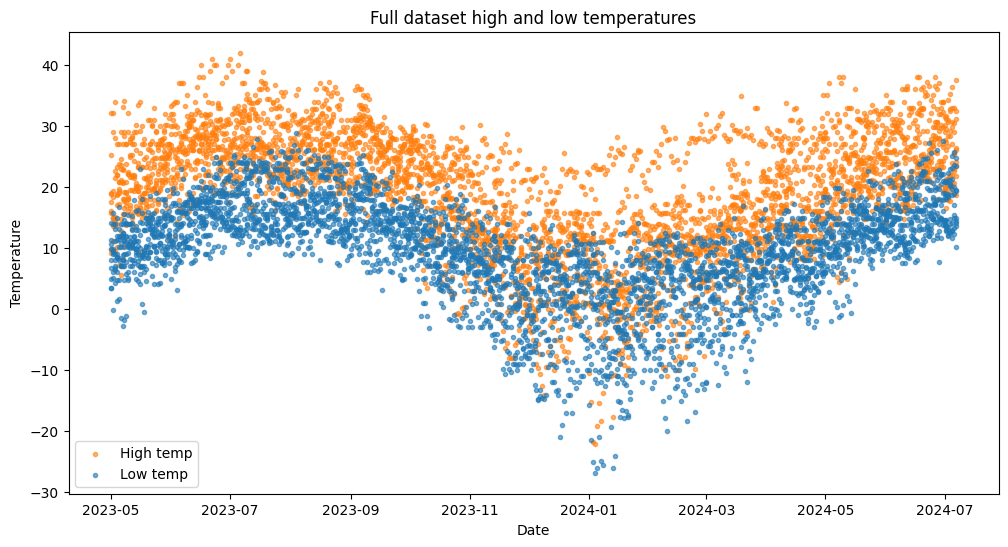

In [3]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [4]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

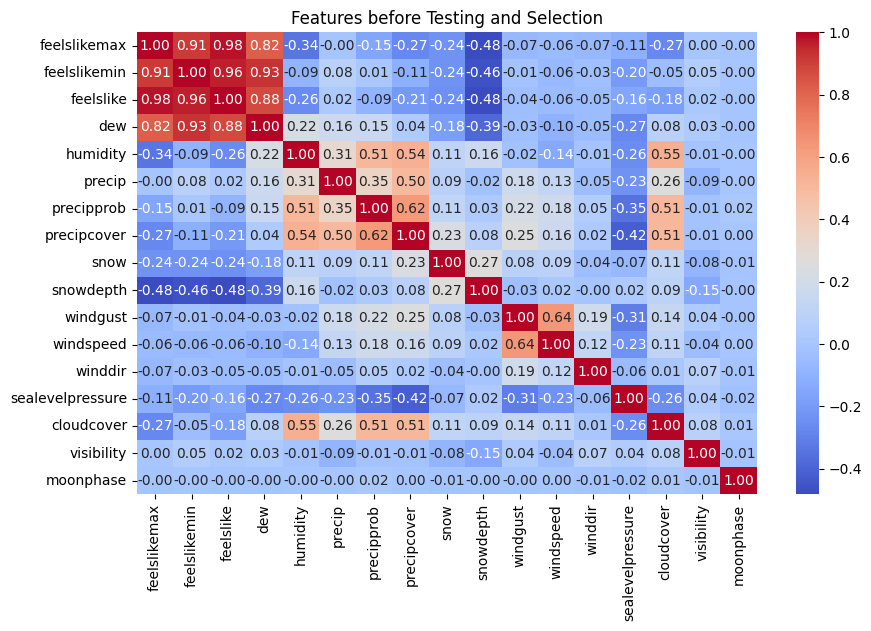

In [7]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(10, 6))
plt.title("Features before Testing and Selection")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Feature Selection and Engineering

In [8]:
# Define the DataFrame with combined highly correlated features for tempmax and tempmin
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'winddir', 'visibility']]

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'snow', 'snowdepth', 'winddir', 'visibility']]


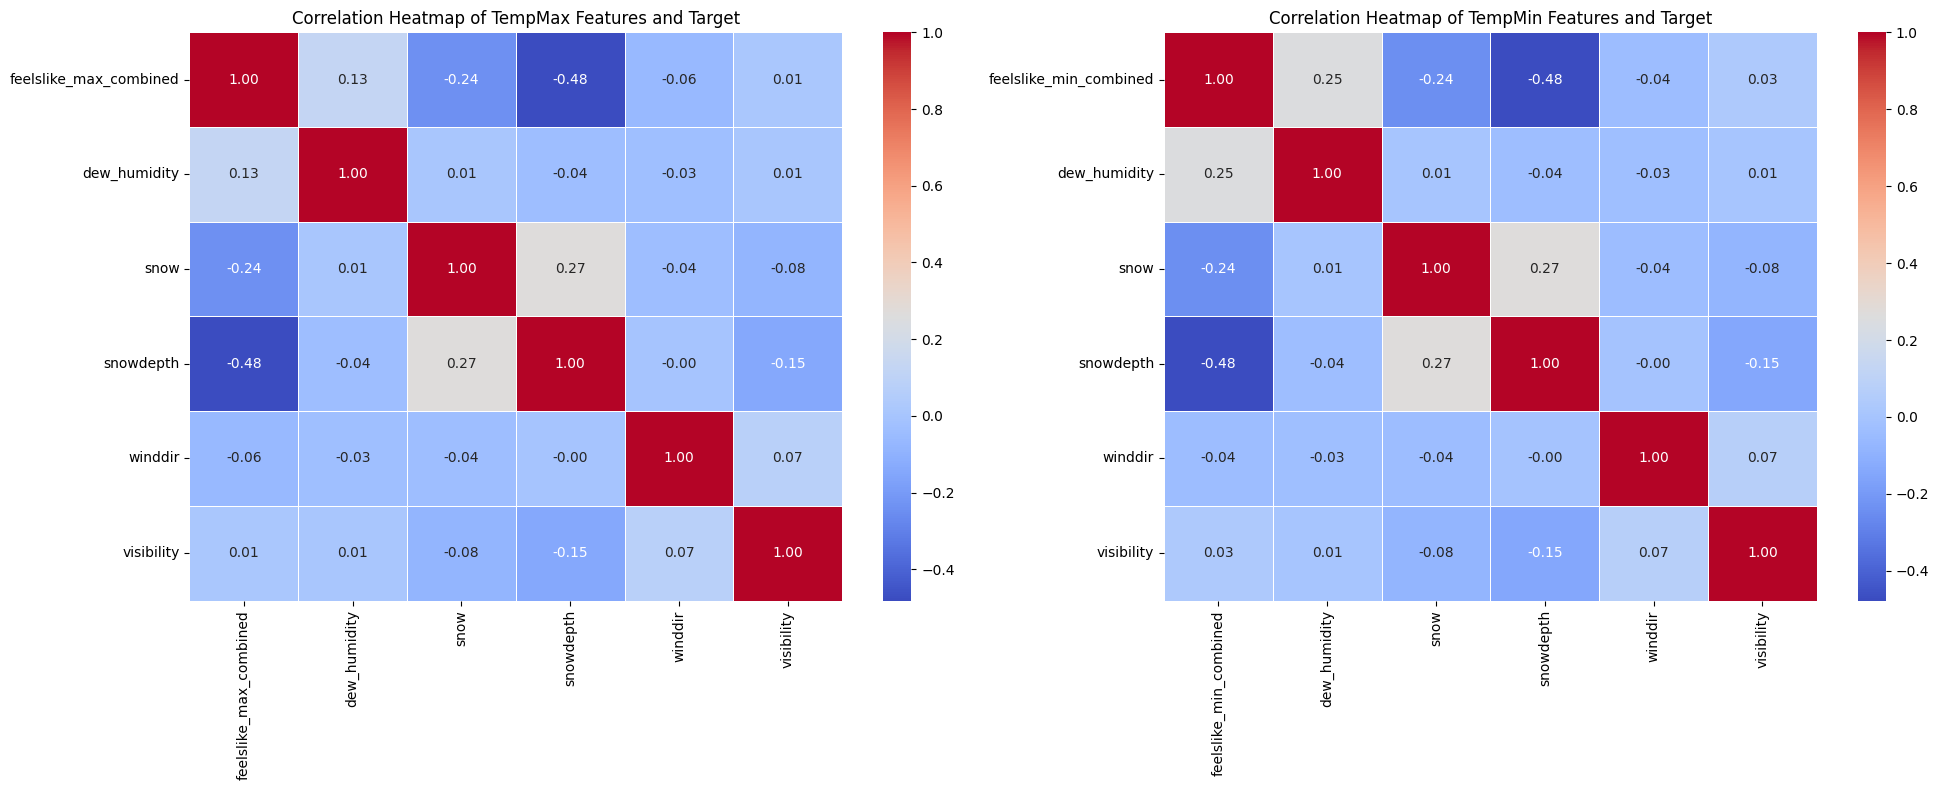

In [9]:
matrix_max = features_combined_max.corr()
matrix_min = features_combined_min.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot heatmap for TempMax
sns.heatmap(matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()

In [10]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

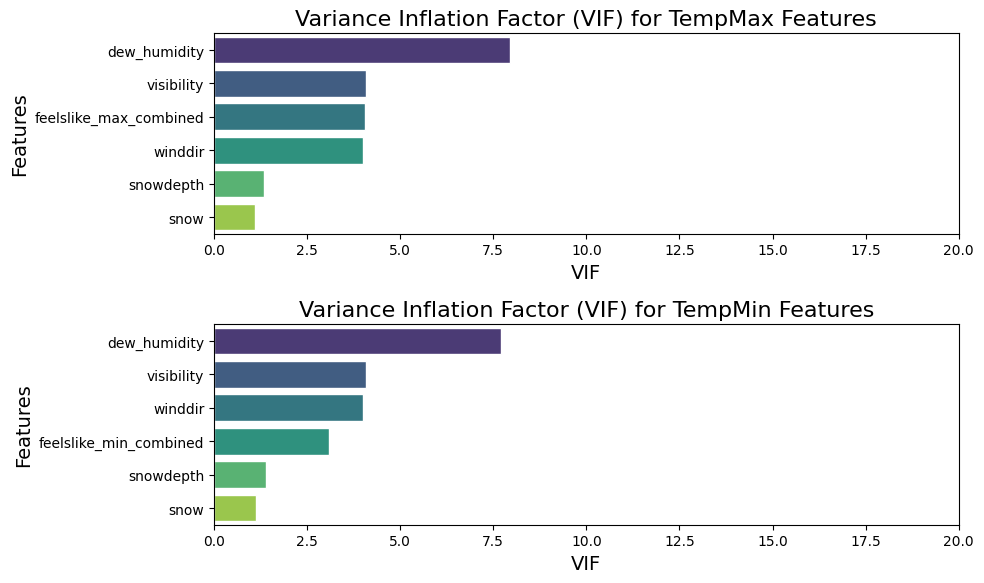

In [11]:
# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 20)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 20)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

## Data Splitting - Train/Validate/Test

In [12]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X_max = ['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']
X_min = ['feelslike_min_combined', 'dew_humidity', 'snow', 'snowdepth', 'winddir']

# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

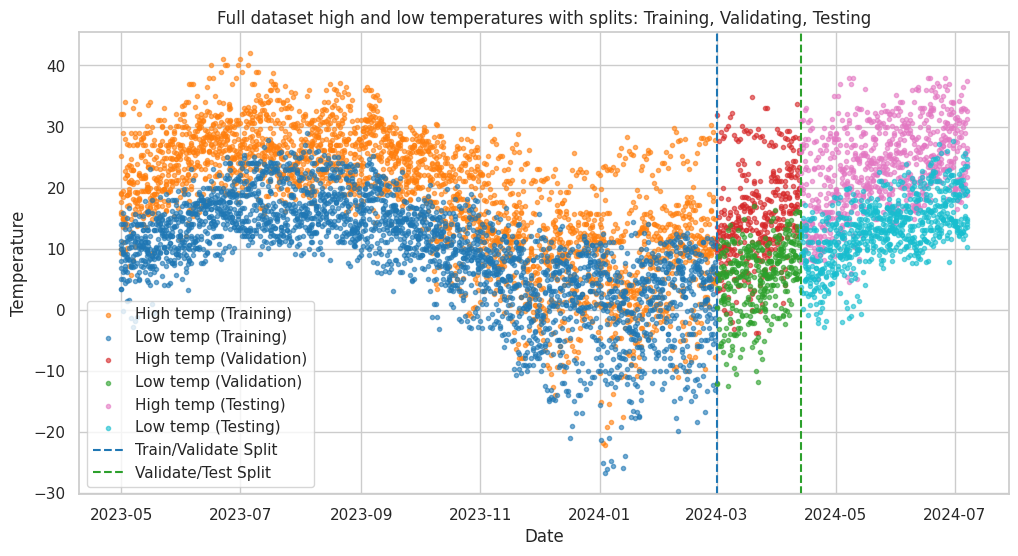

In [13]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Define Target Variables and Feature Sets

In [14]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_validate_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_validate_min = validate[X_min]
X_test_min = test[X_min]

## Model Training and Evaluation

In [15]:
import pmdarima as pm
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Auto ARIMA to find best model orders
stepwise_fit_max = pm.auto_arima(y_train_max, exogenous=X_train_max, trace=True, suppress_warnings=True)
stepwise_fit_min = pm.auto_arima(y_train_min, exogenous=X_train_min, trace=True, suppress_warnings=True)

print("------------------- ARIMA MAX -----------------")
print(stepwise_fit_max.summary())
print("------------------- ARIMA MIN -----------------")
print(stepwise_fit_min.summary())

# Train and fit the models on best orders based on auto_arima results
arima_max = ARIMA(y_train_max, order=stepwise_fit_max.order, exog=X_train_max)
arima_max = arima_max.fit()
print(arima_max.summary())

arima_min = ARIMA(y_train_min, order=stepwise_fit_min.order, exog=X_train_min)
arima_min = arima_min.fit()
print(arima_min.summary())

# Define start and end points for prediction
start = len(y_train_max)
end = start + len(y_test_max) - 1

# Predict using the ARIMA models
arima_pred_max = arima_max.predict(start=start, end=end, exog=X_test_max, typ='levels')
arima_pred_min = arima_min.predict(start=start, end=end, exog=X_test_min, typ='levels')

# Ensure the predictions have the correct index
arima_pred_max.index = y_test_max.index
arima_pred_min.index = y_test_min.index


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13808.687, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14006.872, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13974.708, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13957.591, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14004.881, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13806.756, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13860.258, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13812.153, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13808.598, Time=1.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13823.072, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13807.058, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13810.736, Time=0.87 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13804.805, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13858.278, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0

RMSE for ARIMA TempMax: 1.2187408262839021
RMSE for ARIMA TempMin: 1.3641264209812474


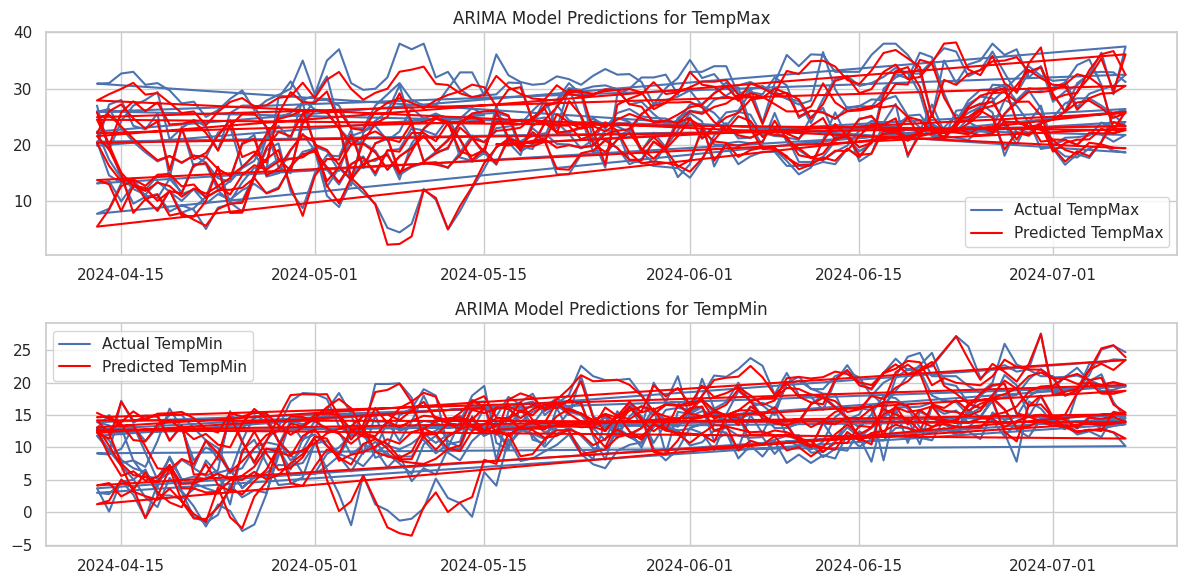

In [16]:
# Calculate RMSE for TempMax
rmse_max = np.sqrt(mean_squared_error(y_test_max, arima_pred_max))
print(f'RMSE for ARIMA TempMax: {rmse_max}')

# Calculate RMSE for TempMin
rmse_min = np.sqrt(mean_squared_error(y_test_min, arima_pred_min))
print(f'RMSE for ARIMA TempMin: {rmse_min}')

# Plot the predicted ARIMA values against the validate values
plt.figure(figsize=(12, 6))

# TempMax predictions
plt.subplot(2, 1, 1)
plt.plot(y_test_max, label='Actual TempMax')
plt.plot(arima_pred_max, label='Predicted TempMax', color='red')
plt.title('ARIMA Model Predictions for TempMax')
plt.legend()

# TempMin predictions
plt.subplot(2, 1, 2)
plt.plot(y_test_min, label='Actual TempMin')
plt.plot(arima_pred_min, label='Predicted TempMin', color='red')
plt.title('ARIMA Model Predictions for TempMin')
plt.legend()

plt.tight_layout()
plt.show()

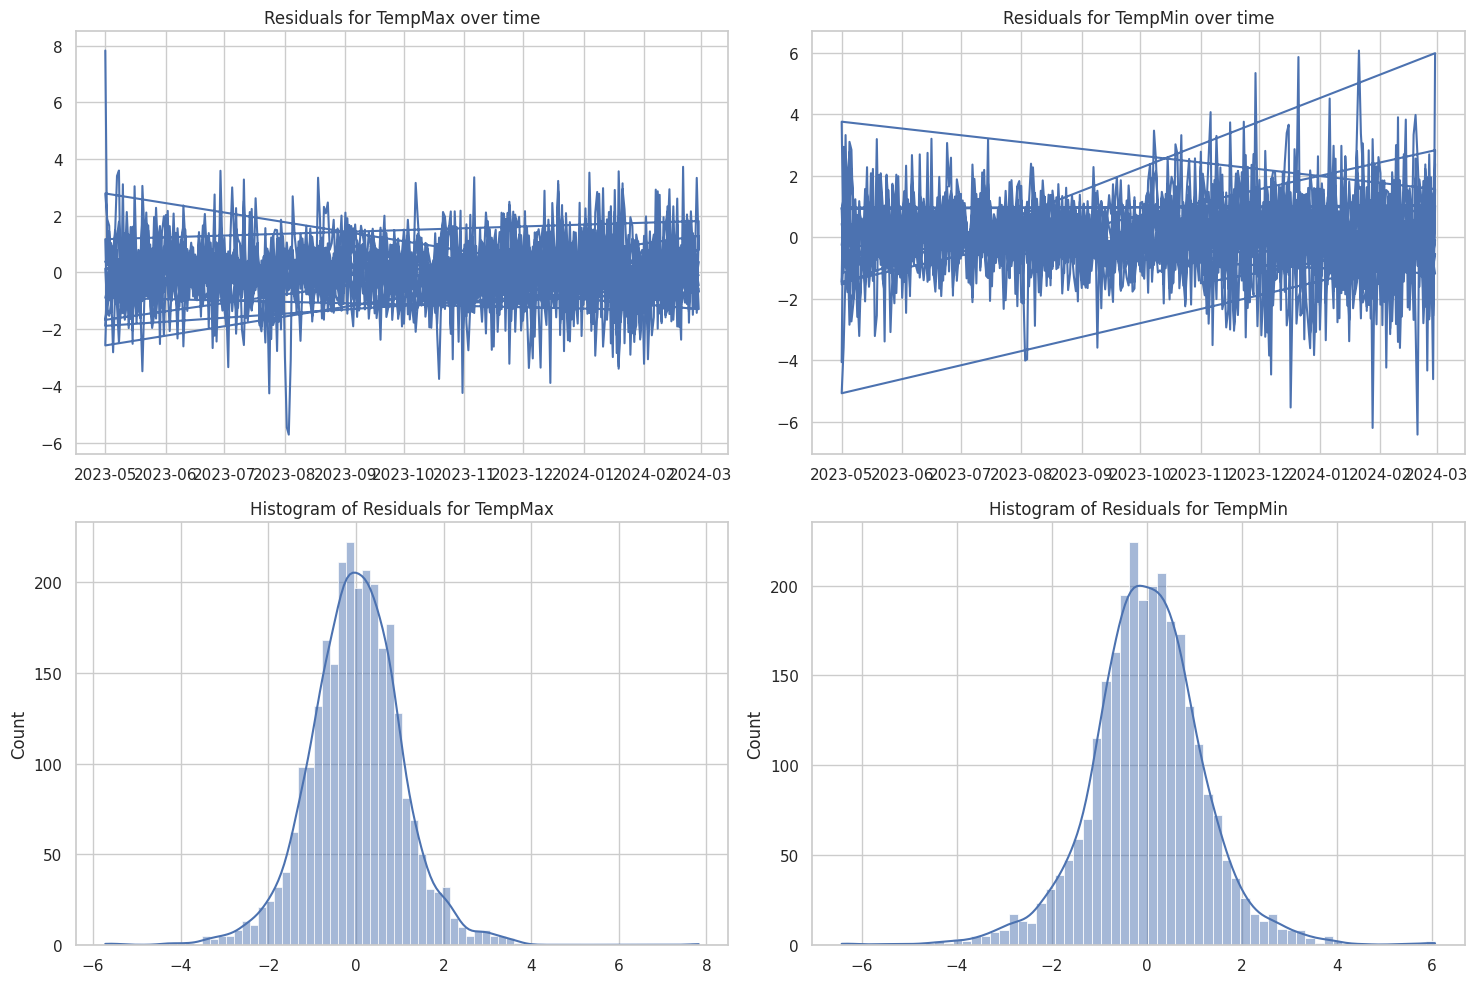

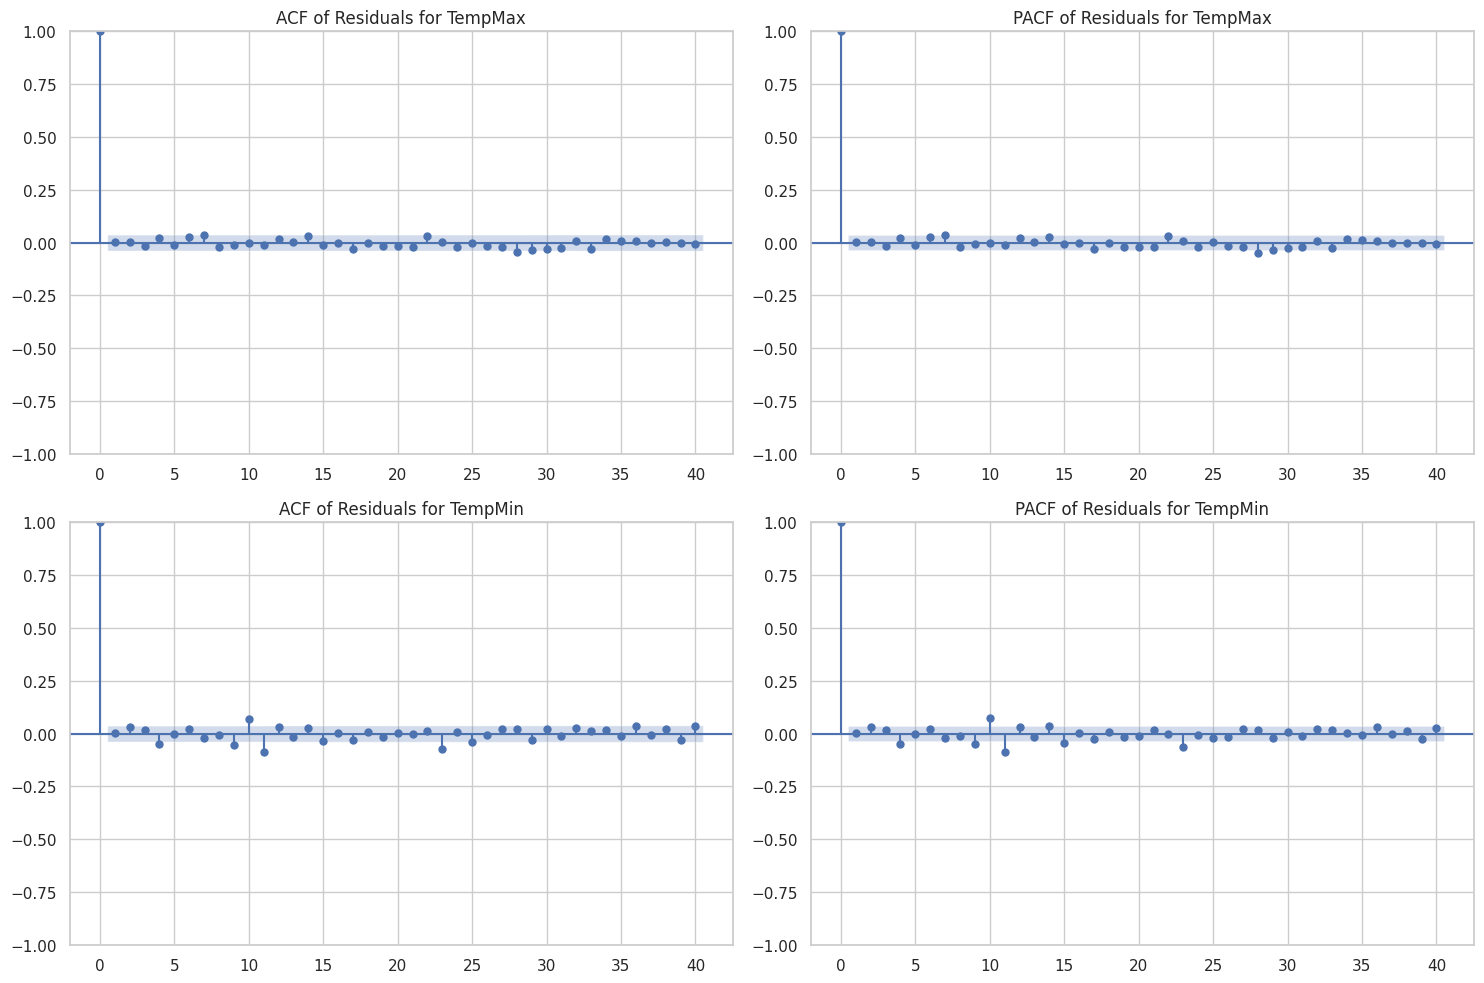

Breusch-Godfrey Test Results for TempMax:
LM Statistic: 45.44136123561007
p-value: 0.25572093885574493
F-Statistic: 1.0266550230939415
p-value: 0.42462051457640054

Breusch-Godfrey Test Results for TempMin:
LM Statistic: 100.32242885336368
p-value: 4.327400424916879e-07
F-Statistic: 2.474222100353061
p-value: 9.320462588233038e-07


In [17]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Extract residuals
residuals_max = arima_max.resid
residuals_min = arima_min.resid

# Plot residuals
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Residuals over time
axs[0, 0].plot(residuals_max)
axs[0, 0].set_title('Residuals for TempMax over time')
axs[0, 1].plot(residuals_min)
axs[0, 1].set_title('Residuals for TempMin over time')

# Histogram of residuals
sns.histplot(residuals_max, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Histogram of Residuals for TempMax')
sns.histplot(residuals_min, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Histogram of Residuals for TempMin')

plt.tight_layout()
plt.show()

# ACF and PACF plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sm.graphics.tsa.plot_acf(residuals_max, lags=40, ax=axs[0, 0])
axs[0, 0].set_title('ACF of Residuals for TempMax')
sm.graphics.tsa.plot_pacf(residuals_max, lags=40, ax=axs[0, 1])
axs[0, 1].set_title('PACF of Residuals for TempMax')

sm.graphics.tsa.plot_acf(residuals_min, lags=40, ax=axs[1, 0])
axs[1, 0].set_title('ACF of Residuals for TempMin')
sm.graphics.tsa.plot_pacf(residuals_min, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('PACF of Residuals for TempMin')

plt.tight_layout()
plt.show()

# Perform Breusch-Godfrey test
bg_test_max = sm.stats.acorr_breusch_godfrey(arima_max, nlags=40)
bg_test_min = sm.stats.acorr_breusch_godfrey(arima_min, nlags=40)

print("Breusch-Godfrey Test Results for TempMax:")
print(f"LM Statistic: {bg_test_max[0]}")
print(f"p-value: {bg_test_max[1]}")
print(f"F-Statistic: {bg_test_max[2]}")
print(f"p-value: {bg_test_max[3]}")

print("\nBreusch-Godfrey Test Results for TempMin:")
print(f"LM Statistic: {bg_test_min[0]}")
print(f"p-value: {bg_test_min[1]}")
print(f"F-Statistic: {bg_test_min[2]}")
print(f"p-value: {bg_test_min[3]}")


In [18]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistic
dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals ARIMA: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals ARIMA: {dw_stat_min}')

Durbin-Watson Statistic for TempMax Residuals ARIMA: 1.9772623806224394
Durbin-Watson Statistic for TempMin Residuals ARIMA: 1.9915758878919854


In [19]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

In [21]:
print(vif_data_max, '\n')
print(vif_data_min)

          tempmax feature       VIF
0  feelslike_max_combined  4.042680
1            dew_humidity  7.961515
2                    snow  1.111511
3               snowdepth  1.353116
4                 winddir  4.011996
5              visibility  4.085543 

          tempmin feature       VIF
0  feelslike_min_combined  3.083947
1            dew_humidity  7.701075
2                    snow  1.117183
3               snowdepth  1.403705
4                 winddir  3.995117
5              visibility  4.074704
